# TalkingData Ad-tracking Fraud Detection



Fraud risk is everywhere, but for companies that advertise online, click fraud can happen at an overwhelming volume, resulting in misleading click data and wasted money. 

> This project involves investigating user’s click behavior
and download rate. The goal is to *predict whether a user will download an app after clicking a mobile app ad*.
  
* This competition is a binary classification problem - our **target variable** is a binary attribute (Is the user making the click fraudlent or not?) and our goal is to classify users into **"fraudlent"** or **"not fraudlent"** 
*   The evaluation metric used is **AUC**-**ROC** (the area under a curve on a Receiver Operator Characteristic graph)


In this machine learning project, you will build a machine learning model to determine whether a click is fraud or not.




In [0]:
import numpy as np 
import pandas as pd 
import datetime
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings; warnings.simplefilter('ignore')

In [2]:
#make wider graphs
sns.set(rc={'figure.figsize':(12,5)})
plt.figure(figsize=(12,5))
plt.style.use('seaborn-white')
sns.set(style="white")

<Figure size 864x360 with 0 Axes>

For this part I use the first **10M** rows from training dataset ( as the complete sets are too big ) and the full test data.

In [0]:
train= pd.read_csv("/content/drive/My Drive/TalkingData AdTracking Fraud Detection/train.csv.zip", nrows = 10000000)
test = pd.read_csv("/content/drive/My Drive/TalkingData AdTracking Fraud Detection/test.csv") 
train_sample = pd.read_csv("/content/drive/My Drive/TalkingData AdTracking Fraud Detection/train_sample.csv")

## Exploratory Data Analysis (EDA)


### Train and Test datasets

That makes **185 million** rows in the training set and **19 million** in the test set. Handily the organisers have provided a **train_sample.csv*** which contains **100K** rows in case you don't have enough memory to load the full dataset.



In [4]:
print(train.shape,test.shape)

(10000000, 8) (18790469, 7)


### Data Overview
TalkingData provides training data for ***185 million samples***, including data between 2017.11.06 and 2017.11.09. Each row of the dataset contains a click record, with the following features:

* **ip**: ip address of click.
* **app**: the app id provided by the advertiser.
* **device**: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
* **os**: operating system version id of user mobile phone.
* **channel**: the ad distribution channel id.
* **click_time**: timestamp of click (UTC), the format is yyyy-mm-dd hh:mm:ss
* **attributed_time**: If the user downloads the app, this is the download time.
* **is_attributed**: whether the app is downloaded, this is the target variable.

**Notes:**

* **is_attributed** is a binary target to predict indicating the app was downloaded
* **ip, app, device, os, channel** are encoded
* **attributed_time** is not available in the test set




In [5]:
# Features are available in the dataset
print(train.columns.values)

['ip' 'app' 'device' 'os' 'channel' 'click_time' 'attributed_time'
 'is_attributed']


In [6]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0


In [7]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ip,10000000.0,87331.722813,55675.273885,9.0,42164.0,81973.0,121187.0,212774.0
app,10000000.0,12.859638,16.526798,0.0,3.0,12.0,15.0,675.0
device,10000000.0,33.038712,308.829766,0.0,1.0,1.0,1.0,3545.0
os,10000000.0,24.600080,61.598780,0.0,13.0,18.0,19.0,745.0
channel,10000000.0,252.660405,130.037570,0.0,134.0,237.0,377.0,498.0
is_attributed,10000000.0,0.001872,0.043223,0.0,0.0,0.0,0.0,1.0


### Missing Values
**attributed_time** have missing values on training set and it's not available in the test set.




In [8]:
missingValue = pd.DataFrame(train.iloc[:,2:].isnull().sum(axis=0).sort_values(ascending=False),columns=['NaN'])
missingValue["Percentage"]= missingValue.NaN.apply(lambda x: '{:.2f}%'.format((float(x)/train.shape[0])*100))
missingValue[missingValue.NaN > 0] 

,NaN,Percentage
attributed_time,9981283,99.81%


Since blank entries in **attributed_time** is matching with *application not downloaded* in train data, we don't need do any further action on this. And also notice that, attributed_time is not present in test data, so no point of keeping it in the train data too.

In [9]:
# Lets check the target variable how many are not downloaded in train data. 
sum(train['is_attributed']==0)

9981283

### Analyzing Features
Let’s check out the unique values per feature in our training data
* As expected, **ip address** is the largest feature with unique values, while **channel** is the one with fewer unique values.



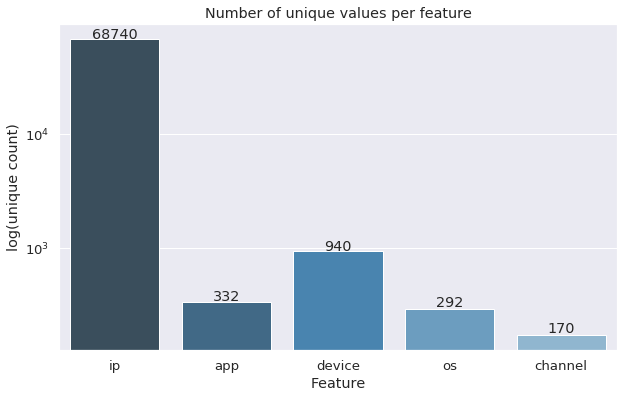

In [10]:
plt.figure(figsize=(10, 6))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette="Blues_d", log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

### Target Variable (is_attributed)
- What is the percentage of a click leading to an app download?

- About **99.81%** of clicks are fraud.  The data set is highly **imbalanced**. Only **0.19%**  of the dataset is made up of fradulent clicks. This means that any models we run on the data will either need to be robust against class imbalance so I choose to balance the data using **oversampling** technique. 


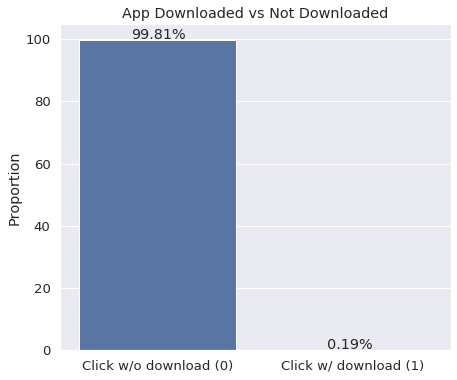

In [11]:
plt.figure(figsize=(7, 6))
sns.set(font_scale=1.2)
download_rate = train['is_attributed'].value_counts(normalize=True)*100
ax = sns.barplot(['Click w/o download (0)', 'Click w/ download (1)'], download_rate)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()), (p.get_x()+p.get_width()/3, p.get_height()+0.1))
    ax.set(xlabel='', ylabel='Proportion', title='App Downloaded vs Not Downloaded')


### Data Distribution

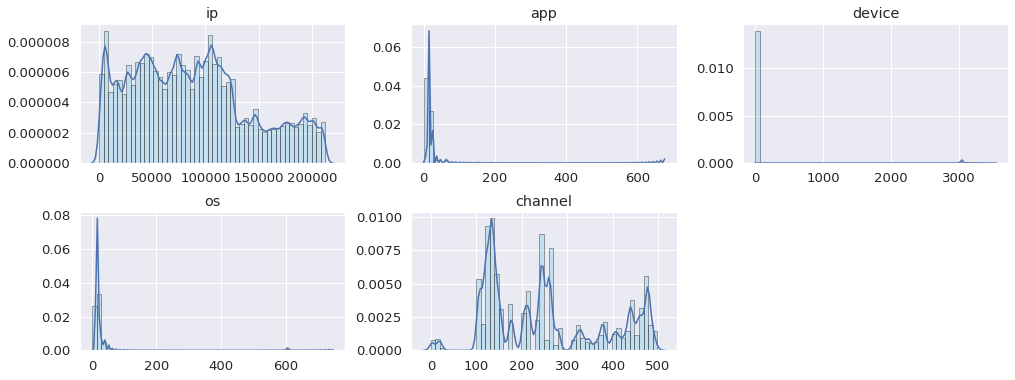

In [12]:
def dist_plot(df, features, n_rows, n_cols):
    fig = plt.figure(figsize=(15,6))
    for i, features in enumerate(features):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        sns.distplot(df[features],hist_kws=dict(edgecolor="k", linewidth=1,color='skyblue'))
        plt.title(features)
        plt.xlabel('')

cols = ['ip', 'app', 'device', 'os', 'channel']        
dist_plot(train, cols , 2, 3)
# Subplots spacing
plt.subplots_adjust(left=0.04, right=0.9, wspace=0.25, hspace=0.35)

In [0]:
def displayCountAndPercentage(df, groupby, countby):
    counts = train[[groupby]+[countby]].groupby(groupby, as_index=False).count().sort_values(countby, ascending=False)
    percentage = train[groupby].value_counts(normalize=True)*100
    ax = sns.barplot(x=groupby, y="is_attributed", data=counts[:10], order=counts[groupby][:10])
    ax.set(ylabel='Number of click', title='Top 10 Click and Percentcage of Feature: ({})'.format(groupby))
 
    i = 0
    for p in ax.patches:    
        ax.annotate('{:.2f}%'.format(percentage.iloc[i]), (p.get_x()+p.get_width()/3, p.get_height()+0.5))
        i = i + 1
 
    del counts, percentage

As expected, ip address is the largest feature with unique values, while channel is the one with fewer unique values. 

And we take a look on the distribution of our features, first, we go for **ip**.

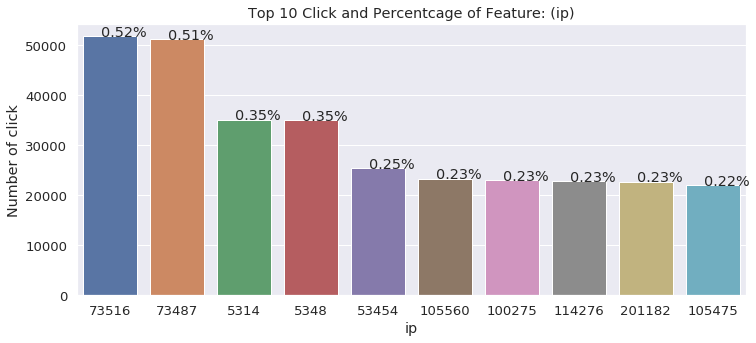

In [14]:
displayCountAndPercentage(train, 'ip', 'is_attributed')

After that, we use the same function on **channel**, **app**, **os** and **device** features.  



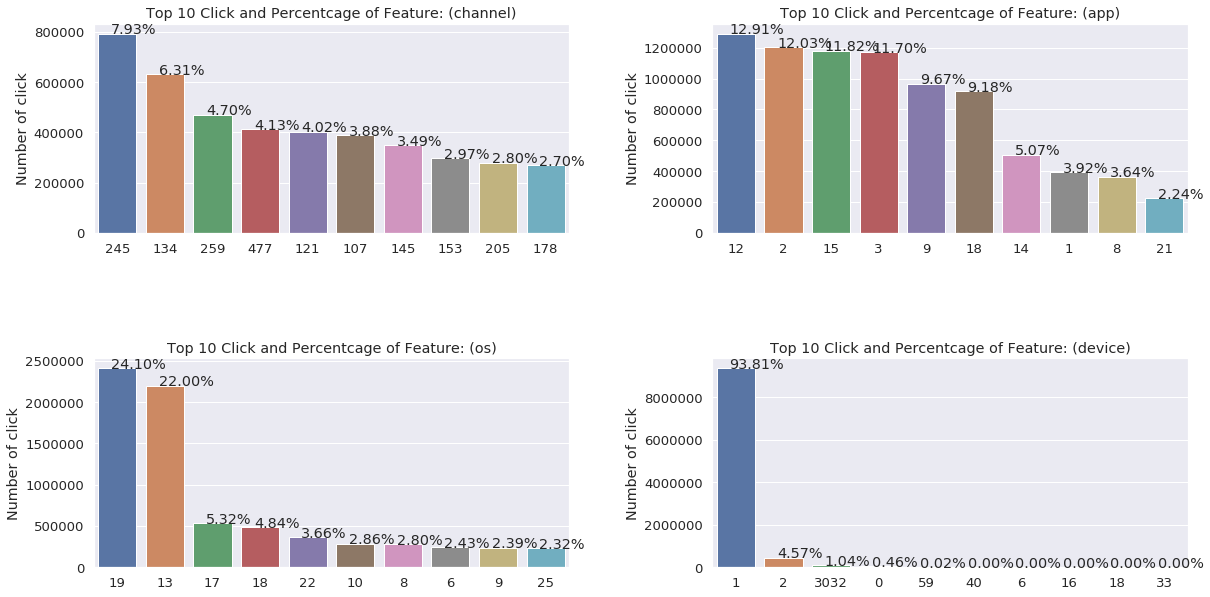

In [15]:
def sub_plot(df, features, n_rows, n_cols):
    fig = plt.figure(figsize=(20,10))
    for i, features in enumerate(features):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        displayCountAndPercentage(df, features, 'is_attributed')
        plt.xlabel('')

cols = ['channel', 'app', 'os', 'device']
sub_plot(train, cols , 2, 2)
# Subplots spacing
plt.subplots_adjust(left=0.04, right=0.8, wspace=0.30, hspace=0.60)

### Relationship between Number of Click and Download Rate
We know certain values dominated a feature, but how do they take part in the download rate? Let’s find it out. This time, we take a look on the top 10 clicks in each feature, and see how they perform in term of download rate. We go for the ‘device’ feature first this time.

In [0]:
def displayCountAndDownloadRate(df, groupby, countby, top):
   counts = df[[groupby]+[countby]].groupby(groupby, as_index=False).count().sort_values(countby, ascending=False)       
   download_rates = df[[groupby]+[countby]].groupby(groupby, as_index=False).mean().sort_values(countby, ascending=False)
   df_merge = counts.merge(download_rates, on=groupby, how='left')
   df_merge.columns = [groupby, 'click_count', 'download_rate']
   df_merge[groupby] = df_merge[groupby].astype('category')
   ax = df_merge[:top].plot(x=groupby, y="download_rate", legend=False, kind="bar", color="lightblue", label="Download rate")
   ax2 = ax.twinx()
   df_merge[:top].plot(x=groupby, y="click_count", ax=ax2, legend=False, kind="line", color="blue",  label="Click count")
   ax.set_xticklabels(df_merge[groupby])
   ax.figure.legend(loc='upper left')
   ax.set_title("Top {} click counts and download rates of {}".format(top, groupby)) 
   ax.set(ylabel='Download rate')
   ax.set_xlim((-0.8,10))
   plt.ylabel('Click count')
   #print(df_merge[:top])


<function matplotlib.pyplot.show>

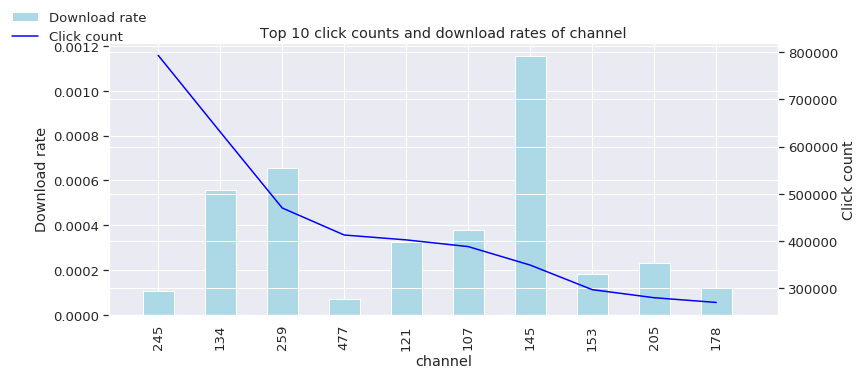

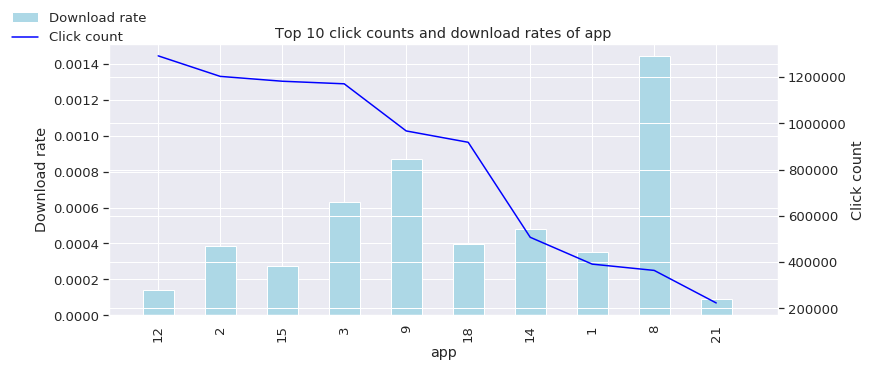

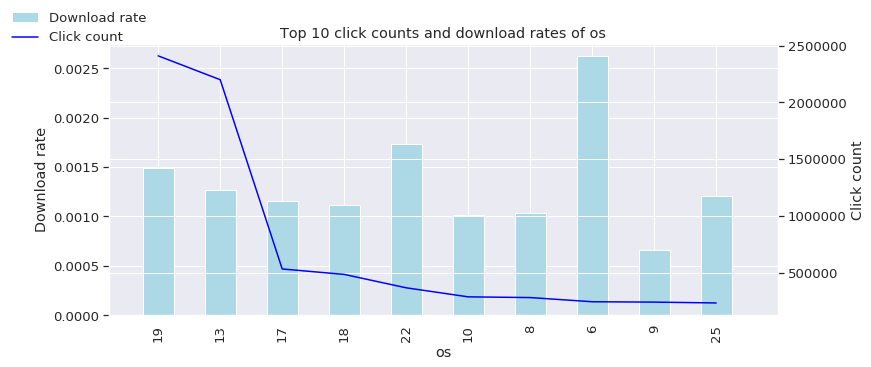

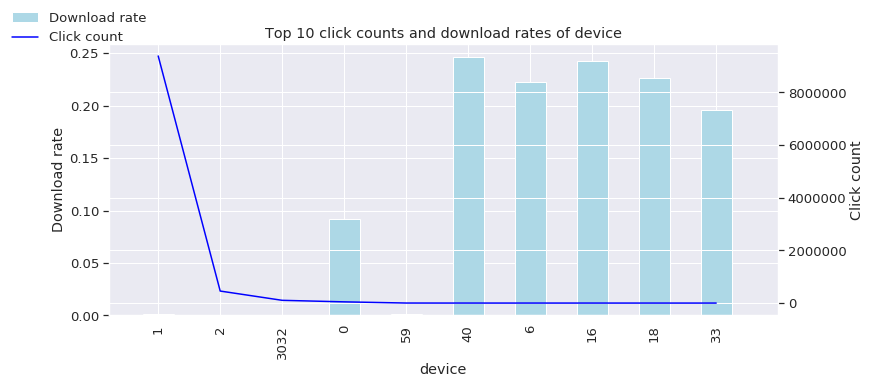

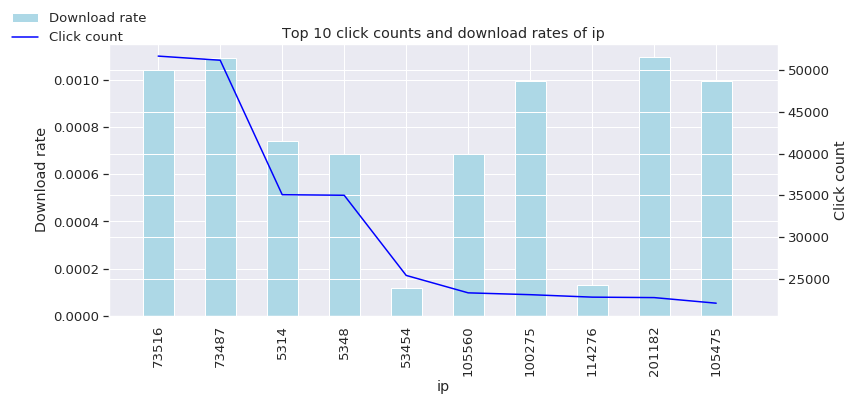

In [17]:
plot_list = ['channel', 'app', 'os', 'device','ip']
for i in plot_list:
    displayCountAndDownloadRate(train, i, 'is_attributed', 10)
plt.show

**There are some findings from above charts**:
- Android OS hardly make an impact on download rate, it matches our observation on top device Click/Download rate chart. The top 10 ip clickers did download although their download rates are small. For channel and app, the download rate does not correlate the number of clicks much. Certain apps and channels just out-download others, no matter the size of clicks.

### Explore ip counts. Check if multiple ips have any downloads.

In [18]:
#temporary table to see ips with their associated count frequencies
temp = train['ip'].value_counts().reset_index(name='counts')
temp.columns = ['ip', 'counts']
temp[:10]

,ip,counts
0,73516,51711
1,73487,51215
2,5314,35073
3,5348,35004
4,53454,25381
5,105560,23289
6,100275,23070
7,114276,22774
8,201182,22719
9,105475,22047


In [19]:
#add temporary counts of ip feature ('counts') to the train table, to see if IPs with high counts have click downloaded
train_ip = train.merge(temp, on='ip', how='left')

train_ip[train_ip['is_attributed']==1].sort_values('counts', ascending=False)[:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,counts
7912764,73516,34,1,19,243,2017-11-06 23:28:13,2017-11-07 01:13:45,1,51711
289189,73516,19,3033,21,213,2017-11-06 16:05:33,2017-11-06 16:05:52,1,51711
3350587,73516,72,1,18,101,2017-11-06 17:46:37,2017-11-07 09:46:44,1,51711
3416495,73516,10,1,25,377,2017-11-06 17:50:33,2017-11-06 18:50:59,1,51711
6331848,73516,29,1,14,213,2017-11-06 22:36:25,2017-11-07 02:10:05,1,51711
7543731,73516,155,1,19,213,2017-11-06 23:18:10,2017-11-07 15:07:40,1,51711
5144374,73516,9,1,37,234,2017-11-06 20:49:25,2017-11-06 20:53:19,1,51711
3651360,73516,107,1,19,171,2017-11-06 18:05:12,2017-11-06 23:44:44,1,51711
6368416,73516,10,1,13,377,2017-11-06 22:38:04,2017-11-06 22:52:43,1,51711
2073360,73516,9,1,13,134,2017-11-06 16:52:12,2017-11-06 16:52:20,1,51711


## Does Time matter?
Round the click time down to an hour of the day to see if there are any **hourly patterns**.

For this part cannot use the first n rows from train data, as it's organized by time. To get a general idea for the pattern, will use train data from the randomly sampled 100000 train set provided by organizers.


In [0]:
train_sample = pd.read_csv('/content/drive/My Drive/TalkingData AdTracking Fraud Detection/train_sample.csv')

In [0]:
#convert click_time and attributed_time to time series
train_sample['click_time'] = pd.to_datetime(train_sample['click_time'])
train_sample['attributed_time'] = pd.to_datetime(train_sample['attributed_time'])

In [22]:
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0


Text(0, 0.5, 'Converted Ratio')

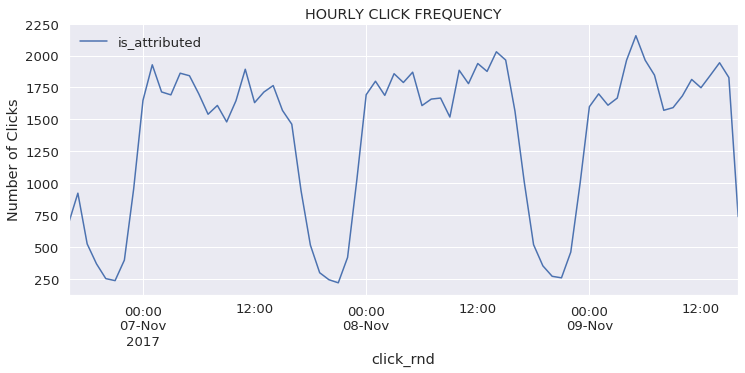

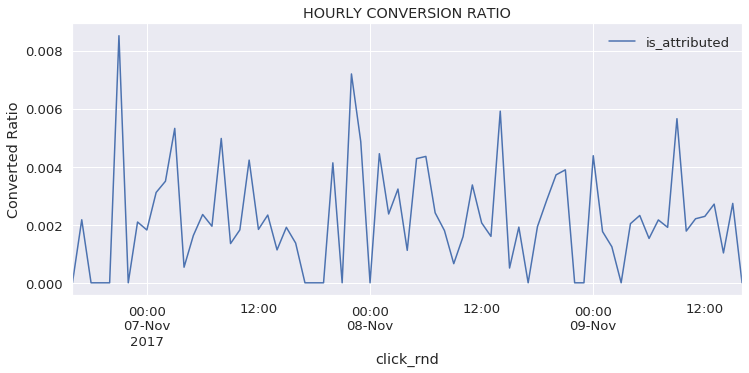

In [23]:
train_sample['click_rnd'] = train_sample['click_time'].dt.round('H')  

#check for hourly patterns
train_sample[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY')
plt.ylabel('Number of Clicks')

train_sample[['click_rnd','is_attributed']].groupby(['click_rnd'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO')
plt.ylabel('Converted Ratio')

There is no clear hourly time pattern, however there is a definite pattern in frequency of clicks based on time of day.

Lets extract the hour of day from each day as a separate feature, and see combined trend (merge the 4 days together by hour).

In [0]:
#extract hour as a feature
train_sample['click_hour']=train_sample['click_time'].dt.hour

In [25]:
train_sample.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour
0,87540,12,1,13,497,2017-11-07 09:30:38,NaT,0,2017-11-07 10:00:00,9
1,105560,25,1,17,259,2017-11-07 13:40:27,NaT,0,2017-11-07 14:00:00,13
2,101424,12,1,19,212,2017-11-07 18:05:24,NaT,0,2017-11-07 18:00:00,18
3,94584,13,1,13,477,2017-11-07 04:58:08,NaT,0,2017-11-07 05:00:00,4
4,68413,12,1,1,178,2017-11-09 09:00:09,NaT,0,2017-11-09 09:00:00,9


Text(0, 0.5, 'Number of Clicks')

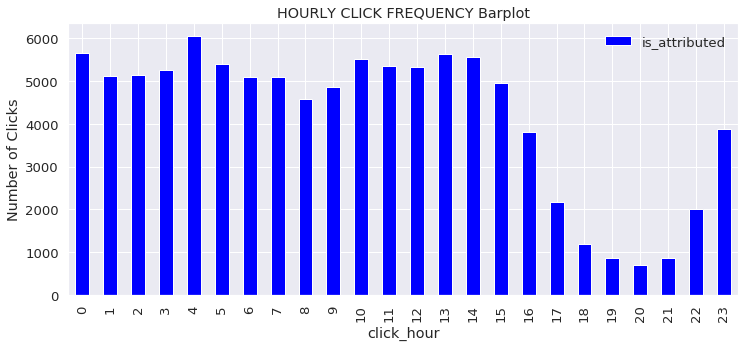

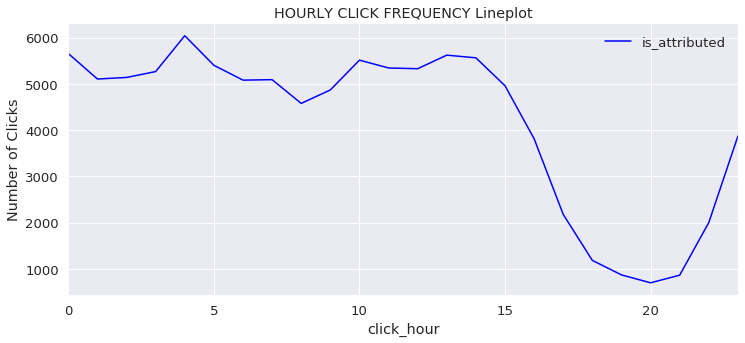

In [26]:
# Let's check number of clicks by hour
train_sample[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(kind='bar', color='blue')
plt.title('HOURLY CLICK FREQUENCY Barplot')
plt.ylabel('Number of Clicks')

train_sample[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).count().plot(color='blue')
plt.title('HOURLY CLICK FREQUENCY Lineplot')
plt.ylabel('Number of Clicks')

Text(0, 0.5, 'Converted Ratio')

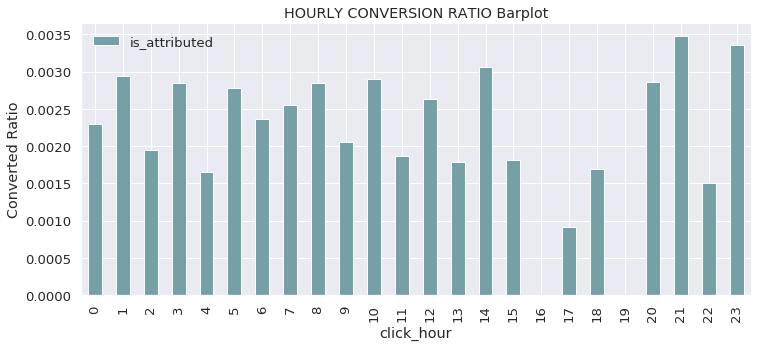

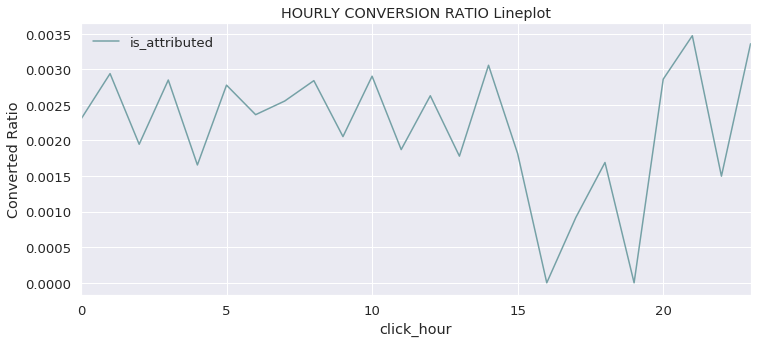

In [27]:
# Number of conversions by hours
train_sample[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot(kind='bar', color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Barplot')
plt.ylabel('Converted Ratio')

train_sample[['click_hour','is_attributed']].groupby(['click_hour'], as_index=True).mean().plot( color='#75a1a6')
plt.title('HOURLY CONVERSION RATIO Lineplot')
plt.ylabel('Converted Ratio')


Let's overlay the two graphs to see if patterns correlate in any way

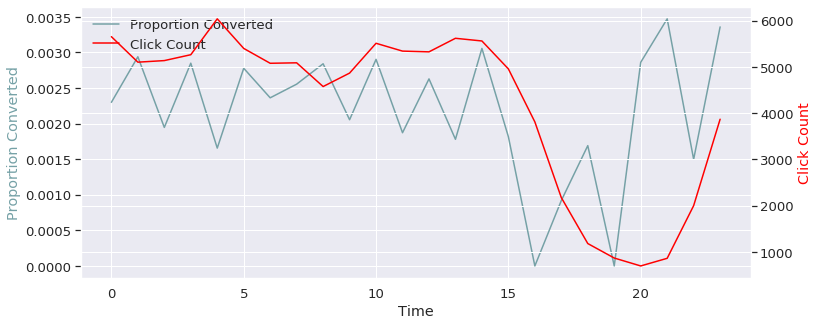

In [32]:
group = train_sample[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).mean()
x = group['click_hour']
ymean = group['is_attributed']
group = train_sample[['click_hour','is_attributed']].groupby(['click_hour'], as_index=False).count()
ycount = group['is_attributed']


fig = plt.figure()
host = fig.add_subplot(111)

par1 = host.twinx()

host.set_xlabel("Time")
host.set_ylabel("Proportion Converted")
par1.set_ylabel("Click Count")

color1 = '#75a1a6'
color2 = 'red'

p1, = host.plot(x, ymean, color=color1,label="Proportion Converted")
p2, = par1.plot(x, ycount, color=color2, label="Click Count")

lns = [p1, p2]
host.legend(handles=lns, loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())


The proportions may be more reliable if estimated on full data. With the random sample it's hard too tell because the variability is too high, especially for the hours with low click counts. 
- The fewer clicks/conversions, the wider margin of the estimated conversion ratio. (see below)

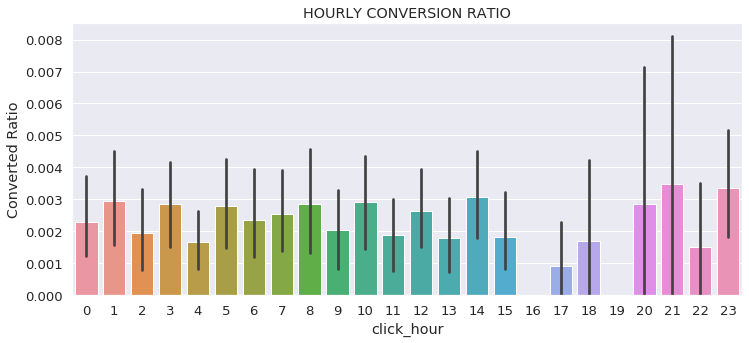

In [33]:
sns.barplot('click_hour', 'is_attributed', data=train_sample)
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

## attributed_time
It could be useful to learn more about conversions that did take place. Let's see how much time passed from clicking on the ad to downloading it.

In [34]:
train_sample['timePass']= train_sample['attributed_time']-train_sample['click_time']
train_sample[train_sample['is_attributed']==1][:10]

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,click_rnd,click_hour,timePass
284,224120,19,0,29,213,2017-11-08 02:22:13,2017-11-08 02:22:38,1,2017-11-08 02:00:00,2,00:00:25
481,272894,10,1,7,113,2017-11-08 06:10:05,2017-11-08 06:10:37,1,2017-11-08 06:00:00,6,00:00:32
1208,79001,19,0,0,213,2017-11-07 09:54:22,2017-11-07 11:59:05,1,2017-11-07 10:00:00,9,02:04:43
1341,131029,19,0,0,343,2017-11-09 10:58:46,2017-11-09 11:52:01,1,2017-11-09 11:00:00,10,00:53:15
1412,40352,19,0,0,213,2017-11-07 22:19:03,2017-11-08 01:55:02,1,2017-11-07 22:00:00,22,03:35:59
1666,48733,35,1,18,274,2017-11-07 12:25:50,2017-11-07 13:10:30,1,2017-11-07 12:00:00,12,00:44:40
1771,330861,35,1,22,21,2017-11-08 18:54:44,2017-11-08 22:39:52,1,2017-11-08 19:00:00,18,03:45:08
1917,309576,5,1,32,113,2017-11-09 08:47:51,2017-11-09 08:47:55,1,2017-11-09 09:00:00,8,00:00:04
3914,220571,71,1,25,3,2017-11-08 04:35:21,2017-11-08 04:37:46,1,2017-11-08 05:00:00,4,00:02:25
3992,240051,35,1,19,21,2017-11-08 08:07:13,2017-11-08 09:46:42,1,2017-11-08 08:00:00,8,01:39:29


In [35]:
train_sample['timePass'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: timePass, dtype: object

It takes as long as (almost) 20 hours to go from click to download and as little as 4 seconds.

The 4 seconds seems to low to make a decision. This person would have either seen the ad before, or already been aware of the product some other way.

Does that mean the ad was clicked on multiple times, but only one click was counted as conversion? Or did the person click on the ad specifically with the intent to download? 

## Let's Check actual train data 
Check the same feature on the first 10 million rows of train data

In [37]:
#check first 10,000,000 of actual train data
train_sample['timePass']= train_sample['attributed_time']-train_sample['click_time']
train_sample['timePass'].describe()

count                       227
mean     0 days 01:14:59.572687
std      0 days 02:25:05.392661
min             0 days 00:00:02
25%      0 days 00:00:52.500000
50%             0 days 00:03:18
75%      0 days 01:21:27.500000
max             0 days 12:52:21
Name: timePass, dtype: object